In [42]:
import sys
import os

sys.path.append(os.getenv("CODE_PATH"))
sys.path.append(os.getenv("FIN_DATABASE_PATH"))

import plotly.graph_objects as go
import pandas as pd
import numpy as np
from sqlalchemy.orm import sessionmaker
from sqlalchemy import create_engine, select
from datetime import datetime, timedelta
import logging
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import ta
from log_config import setup_logging
from Data.connect import engine, DailyStockData, HourlyStockData, OneMinuteStockData, FiveMinuteStockData,FifteenMinuteStockData, StockSplits, StockNews, CompanyFinancials
from Pre_Processing.pre_processing import PreProcessing
from Feature_Engineering.feature_engineering import TechnicalIndicators
from pipeline import Pipeline
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import root_mean_squared_error as rmse
from arch import arch_model

In [43]:
#Defining the tickers
tickers = ['AAPL', 'MSFT', 'SPY']

In [44]:
#Using the pipeline script to retrieve data for the above tickers from the SQL database.

pipe = Pipeline(tickers)
minute_data = pipe.pipeline(timespan='minute',start_date='2018-01-01',end_date='2019-01-01')
hourly_data = pipe.pipeline(timespan='hour',start_date='2018-01-01',end_date='2019-01-01')
daily_data = pipe.pipeline(timespan='daily',start_date='2018-01-01',end_date='2019-01-01')


#### Here we  create the Intraday Vol class.This class will contain the necessary functions to predict the intraday volatility according to the paper.
#### I'm also adding garch as an option for daily volatility

In [45]:
class IntradayVol:
    def __init__(self,tickers, hf_data, lf_data, daily_data, timespan,  decay_factor = 0.94, ret_col='log_ret'):
        """args:
        tickers: list of tickers
        hf_data: higher frequency dataframe
        lf_data: lower frequency dataframe
        daily_data: daily dataframe
        timespan: timespan of the lower frequency data to aggregate : '15M', '1H', '1D', '1W....'
        ret_col = ret_var # name of the column in the DataFrame that contains the returns
        decay_factor: decay factor for the EWMA model. 0.94 is the default value
        """
        self.tickers = tickers
        self.hf_data = hf_data
        self.lf_data = lf_data
        self.daily_data = daily_data
        self.timespan = timespan
        self.decay_factor = decay_factor
        self._ewma_vol_cache = {}
        self.ret_col = ret_col

    
    def ewma_vol(self):
        """Calculate daily vol using EWMA model with caching and modify the DataFrame."""
        if self._ewma_vol_cache: 
            return self._ewma_vol_cache
        
        vol_results = {}
        for ticker in self.tickers:
            df = self.daily_data [ticker] 

            # squared log returns
            df['squared_log_ret'] = df[self.ret_col] ** 2
            df['squared_log_ret'].bfill(inplace=True)

            # Initialising new column for daily vol
            df['daily_vol_squared'] = np.nan
            df.loc[df.index[0], 'daily_vol_squared'] = df['squared_log_ret'].iloc[0]

            # Looping through and calculating the EWMA
            for i in range(1, len(df)):
                df.loc[df.index[i], 'daily_vol_squared'] = (
                    self.decay_factor * df['daily_vol_squared'].iloc[i-1] +
                    (1 - self.decay_factor) * df['squared_log_ret'].iloc[i-1]
                )

            # Calculating ewma_vol
            df['ewma_vol'] = np.sqrt(df['daily_vol_squared'])*np.sqrt(252)

            # Storing the result in the cache
            vol_results[ticker] = df['ewma_vol']
        
        self._ewma_vol_cache = vol_results  # Cache the result
        return vol_results

    
    
    def garch_vol(self, model_type='GARCH'):
        """Calculate daily vol using GARCH(1,1) model and modify the DataFrame.
        We can choose amongst different GARCH models through the model_type parameter"""
        
        vol_results = {}
        for ticker in self.tickers:
            df = self.daily_data[ticker]  
            df.dropna(subset=[self.ret_col], inplace=True)  

            # Fitting GARCH 
            model = arch_model(df[self.ret_col] * 100, vol=model_type, p=1, q=1)
            garch_results = model.fit(disp="off")
            
            # Storing the results
            df['garch_vol'] = (garch_results.conditional_volatility / 100) * np.sqrt(252)

            vol_results[ticker] = df['garch_vol'] 

        return vol_results



    def calculate_diurnal_profile(self):
        """Calculate diurnal profile based on our historical data, using Garman-Klass vol for each time bucket of the day. 
        It is calculated using the aggregated data of the higher frequency data"""
        
        diurnal_results = {}
        for ticker in self.tickers:
            #removing the first datapoint of the day, as it is not a full interval
            df = self.hf_data[ticker]  
            df = df[df.index.time != pd.Timestamp("09:30:00").time()]


            aggregated_df = df.groupby(df.index.ceil(self.timespan)).aggregate({'open': 'first', 
                                                                'high': 'max', 
                                                                'low': 'min', 
                                                                'close': 'last'})
            
            
            garma_klass_vol = np.sqrt(0.5*(np.log(aggregated_df['high']) - np.log(aggregated_df['low']))**2 - (2 * np.log(2) -1) * (np.log(aggregated_df['close']) - np.log(aggregated_df['open']))**2)
            q5 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.05)
            q25 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.25)
            q50 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.5)
            q75 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.75)
            q95 = garma_klass_vol.groupby(aggregated_df.index.time).quantile(0.95)
            
            diurnal_profile = (q25 + q50 + q75) / 3
            diurnal_profile = diurnal_profile / diurnal_profile.mean()
            diurnal_results[ticker] = (diurnal_profile, q5, q25, q50, q75, q95)

        return diurnal_results

    def calculate_dynamic_avg_intraday_vol(self):
        """Dynamically calculating the average intraday vol, so we can 
        scale the daily volatility to the intraday vol"""
        for ticker in self.tickers:
            df = self.lf_data[ticker]
            df['gk_vol'] = np.sqrt(0.5*(np.log(df['high']) - np.log(df['low']))**2 - (2 * np.log(2) -1)
                                        * (np.log(df['close']) - np.log(df['open']))**2)
        
            df['cum_mean_gk_vol'] = df['gk_vol'].expanding().mean()
        
            df['scaling_factor'] = df['cum_mean_gk_vol'] / df['garch_vol']

        return df
    




    def predict_vol(self):
        """Predict volatility for the next interval based on GARCH and intraday factors."""
        self.ewma_vol()  
        self.garch_vol()  
        self.populate_columns()  

        for ticker in self.tickers:
            df = self.lf_data[ticker]

            df = self.calculate_dynamic_avg_intraday_vol()

            # Predict next hour's volatility
            df['predicted_vol'] = df['garch_vol'] * df['dynamic_avg_intraday_vol'] * df['diurnal_component'].shift(-1)
            df['predicted_vol'] = df['predicted_vol'].shift(1)

            # Store the updated df back in lf_data
            self.lf_data[ticker] = df

        return self.lf_data


In [46]:
#Defining plotting functions to help better visualise the diurnal profile and the daily volatility


def plot_diurnal_profile(diurnal_results, combined=False):
    """Plot the diurnal profile with specified intervals on the x-axis."""
    
    if combined:
        for ticker in diurnal_results.keys():
            diurnal_profile, q5, q25, q50, q75, q95 = diurnal_results[ticker]
            times = sorted(diurnal_profile.index.unique())
            
            times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]

            plt.figure(figsize=(12, 6))
            
            plt.plot(times_as_datetime, q50, label="Median (50th percentile)", color='blue')
            

            plt.fill_between(times_as_datetime, q5, q95, color='red', alpha=0.3, label="5th to 95th percentile")
            plt.fill_between(times_as_datetime, q25, q75, color='green', alpha=0.3, label="25th to 75th percentile")
            
            plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
            
            plt.title(f"Diurnal Profile of Garman-Klass Volatility for {ticker}")
            plt.xlabel("Time of Day")
            plt.ylabel("Normalized Volatility")
            plt.grid(True)
            plt.legend()
            
            plt.tight_layout()
            plt.show()
    
    else:
    
        plt.figure(figsize=(12, 6))
        for ticker in diurnal_results.keys():
            diurnal_profile, _, _, _, _, _ = diurnal_results[ticker]
            times = sorted(diurnal_profile.index.unique())
            times_as_datetime = [pd.Timestamp.combine(pd.Timestamp.today(), time) for time in times]
            plt.plot(times_as_datetime, diurnal_profile, label=ticker)
        
        plt.xticks(times_as_datetime, [time.strftime('%H:%M') for time in times_as_datetime], rotation=45)
        plt.title("Combined Diurnal Profile of Garman-Klass Volatility")
        plt.xlabel("Time of Day")
        plt.ylabel("Normalized Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    
def plot_daily_vol(data, vol_type='garch_vol', combined = True):
    """Plot the estimated daily volatility of the stock.
    Here we use the absolute value of the log returns as the observable vol measure.
    args:
        data: dictionary of dataframes where the key is the ticker and the value is the df
        vol_type: either ewma_vol or garch_vol, according to the model you want to use"""
    
    if combined:
        plt.figure(figsize=(12, 6))
        for ticker in data.keys():
            plt.plot(data[ticker].index, data[ticker][vol_type], label=f"{ticker} {vol_type}")
        
        plt.title("Daily Volatility of Stocks")
        plt.xlabel("Date")
        plt.ylabel("Volatility")
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()
    else: 
        for ticker in data.keys():
            plt.figure(figsize=(12, 6))
            plt.plot(data[ticker].index, data[ticker][vol_type], label=f"{ticker} {vol_type}")
            plt.plot(data[ticker].index, np.abs(data[ticker]['log_ret'])*np.sqrt(252), label=f"{ticker} Abs Log Returns")
        
            plt.title(f"Daily Volatility of {ticker} ")
            plt.xlabel("Date")
            plt.ylabel("Volatility")
            plt.grid(True)
            plt.legend()
            plt.tight_layout()
            plt.show()
    
    


In [47]:
#Creating an instance of the IntradayVol class and calling the methods to calculate the daily volatility and the diurnal profile
intraday_vol = IntradayVol(tickers = tickers, hf_data=minute_data, lf_data=hourly_data, daily_data=daily_data, timespan='30T')

In [48]:
intraday_vol.garch_vol()
intraday_vol.ewma_vol()

{'AAPL': date
 2018-01-03    0.002765
 2018-01-04    0.002765
 2018-01-05    0.018218
 2018-01-08    0.047432
 2018-01-09    0.048210
                 ...   
 2018-12-24    0.405812
 2018-12-26    0.406439
 2018-12-27    0.474662
 2018-12-28    0.460898
 2018-12-31    0.446862
 Name: ewma_vol, Length: 250, dtype: float64,
 'MSFT': date
 2018-01-03    0.073706
 2018-01-04    0.073706
 2018-01-05    0.079169
 2018-01-08    0.090484
 2018-01-09    0.087817
                 ...   
 2018-12-24    0.353159
 2018-12-26    0.380424
 2018-12-27    0.449507
 2018-12-28    0.436469
 2018-12-31    0.424268
 Name: ewma_vol, Length: 250, dtype: float64,
 'SPY': date
 2018-01-03    0.100092
 2018-01-04    0.100092
 2018-01-05    0.098411
 2018-01-08    0.098847
 2018-01-09    0.096098
                 ...   
 2018-12-24    0.234989
 2018-12-26    0.250497
 2018-12-27    0.309383
 2018-12-28    0.301429
 2018-12-31    0.292289
 Name: ewma_vol, Length: 250, dtype: float64}

In [49]:
diurnal_results = intraday_vol.calculate_diurnal_profile()

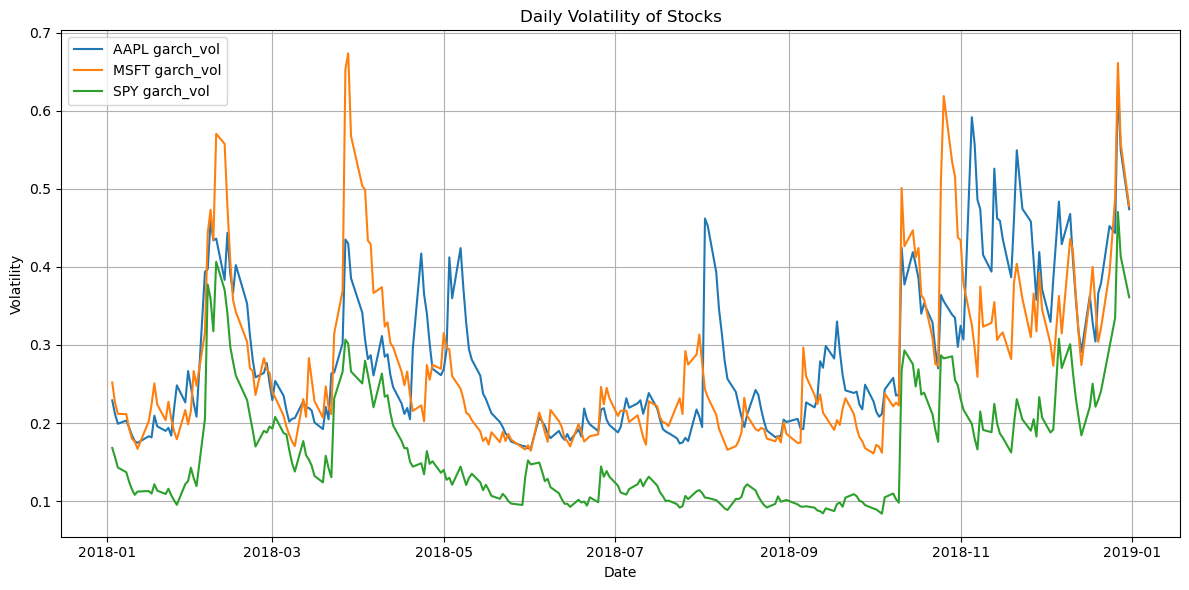

In [50]:
plot_daily_vol(daily_data)

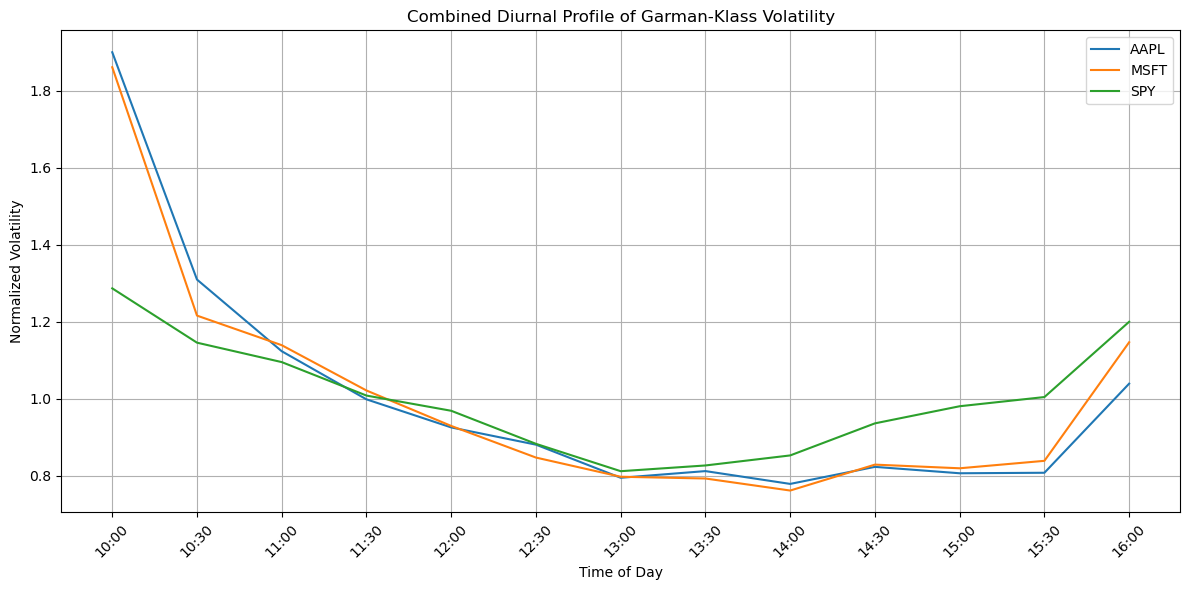

In [51]:
plot_diurnal_profile(diurnal_results)

In [52]:
diurnal_c, q5, q25, q50, q75, q95 = diurnal_results['AAPL']

In [53]:
#Testing AAPL

apple_hour = hourly_data['AAPL']
apple_hour['garch_vol'] = np.nan
apple_hour['ewma_vol'] = np.nan
apple_hour['diurnal_component'] = np.nan
apple_hour['gk_vol'] = np.sqrt(0.5*(np.log(apple_hour['high']) - np.log(apple_hour['low']))**2 - (2 * np.log(2) -1) * (np.log(apple_hour['close']) - np.log(apple_hour['open']))**2)

# Filling the columns
for i in range(len(apple_hour)):
    # Get the current date and time
    current_time = apple_hour.index[i].time()
    current_date = apple_hour.index[i].date()  
    
    # Convert current_date to a Timestamp (for matching with daily_data index)
    current_date_timestamp = pd.Timestamp(current_date)
    
    # Assigning GARCH and EWMA for each day. this would repeat for each hour
    if current_date_timestamp in daily_data['AAPL'].index:
        apple_hour.loc[apple_hour.index[i], 'garch_vol'] = daily_data['AAPL'].loc[current_date_timestamp, 'garch_vol']
        apple_hour.loc[apple_hour.index[i], 'ewma_vol'] = daily_data['AAPL'].loc[current_date_timestamp, 'ewma_vol']
    
    # 3. Assign diurnal component for the current time interval
    if current_time in diurnal_c.index:  # Assume diurnal_c is available
        apple_hour.loc[apple_hour.index[i], 'diurnal_component'] = diurnal_c[current_time]



In [54]:
columns_to_drop = ['ROC', 'Stoch', 'ADX', 'ADX_pos', 'ADX_neg', 'rolling_H-L_25',
       'lower_band', 'ATR', 'IBS', 'OBV', 'sma_5', 'ema_5', 'sma_10', 'ema_10',
       'sma_30', 'ema_30', 'sma_50', 'ema_50', 'sma_100', 'ema_100', 'sma_200',
       'ema_200', 'sma_300', 'ema_300','volume', 'vwap', 'transactions', 'RSI_14', 'RSI_2', 'MACD',
       'id', 'day', 'timestamp', 'month', 'day_of_week'
       ]
apple_hour.drop(columns=columns_to_drop, inplace=True)
apple_hour.dropna(subset=['garch_vol'], inplace=True)

In [55]:
def calculate_dynamic_avg_intraday_vol(df):
        df['cum_mean_gk_vol'] = df['gk_vol'].expanding().mean()

        # Divide by the daily volatility (GARCH or EWMA)
        df['dynamic_avg_intraday_vol'] = df['cum_mean_gk_vol'] / df['garch_vol']

        return df

In [56]:
apple_hour['date_day'] = apple_hour['date'].dt.date  # Add a date column
apple_hour = apple_hour.groupby('date_day').apply(calculate_dynamic_avg_intraday_vol).reset_index(drop=True)
apple_hour['predicted_vol'] = apple_hour['garch_vol'] *apple_hour['dynamic_avg_intraday_vol'] *  (apple_hour['diurnal_component'].shift(-1))
apple_hour['predicted_vol'] = apple_hour['predicted_vol'].shift(1)

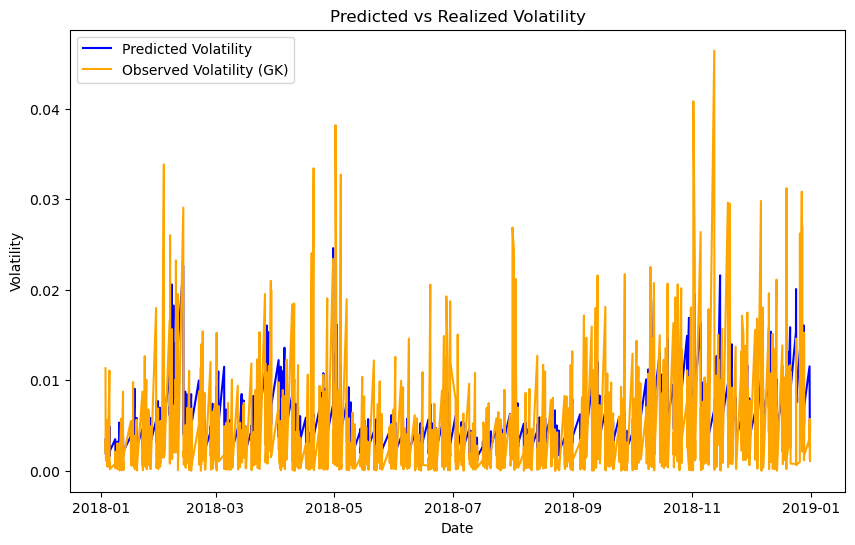

In [57]:
#Plotting Prediction vs observed
plt.figure(figsize=(10, 6))
plt.plot(apple_hour['date'], apple_hour['predicted_vol'], label='Predicted Volatility', color='blue')
plt.plot(apple_hour['date'], np.abs(apple_hour['return']), label='Observed Volatility (GK)', color='orange')
plt.legend()
plt.title("Predicted vs Realized Volatility")
plt.xlabel("Date")
plt.ylabel("Volatility")
plt.show()


In [62]:
rmse((apple_hour['gk_vol']*100).iloc[1:-1], (apple_hour['predicted_vol']*100).iloc[1:-1])

0.30605522419741177